In [31]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

### Reflecting tables to SQLalchemy ORM

In [4]:
# python SQL toolkit and ORM 
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine('sqlite:///resources/hawaii.sqlite')

In [6]:
# reflect an existing database to a new model
# reflecet the tables
base = automap_base()
base.prepare(engine, reflect=True)

In [7]:
# view all the classes found by automap
base.classes.keys()

['measurement', 'station']

In [8]:
# save reference to each table
measurement=base.classes.measurement
station=base.classes.station

In [9]:
# create session link from python db
session=Session(engine)

In [10]:
first_row=session.query(measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f96f807cf10>,
 'id': 1,
 'date': '2010-01-01',
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0}

In [11]:
first_row=session.query(station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f96fa26a790>,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 3.0,
 'id': 1,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168}

### explorative analysis 

#### climate analysis

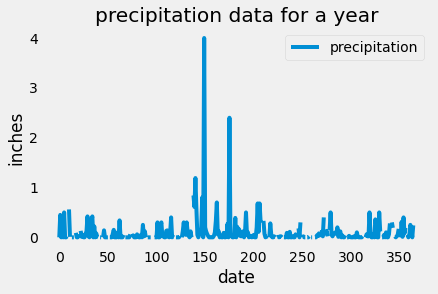

In [53]:
year_data=session.query(measurement.date, measurement.prcp).\
    order_by(measurement.date.desc()).limit(365).all()
year_data_df=pd.DataFrame(year_data, columns=['date', 'precipitation']).\
    sort_values('date', ascending=False).\
    reset_index(drop=True)

# plot the precipatation data
year_data_df.iloc[::-1].plot(title='precipitation data for a year')
plt.tight_layout()
plt.ylabel('inches')
plt.xlabel('date')
plt.grid()
plt.show()

In [54]:
session.query(measurement.date).order_by(measurement.date.desc()).first()
query_date=dt.date(2017,8,23) - dt.timedelta(days=365)
print(f'One year from the last data point in precipitation was :{query_date}')

One year from the last data point in precipitation was :2016-08-23


In [46]:
year_data_df.describe()

,precipitation
count,329.000000
mean,0.107264
std,0.297784
min,0.000000
25%,0.000000
50%,0.020000
75%,0.100000
max,4.000000


#### station analysis

In [47]:
stations_count=session.query(station).group_by(station.station).\
    count()
print(f'There are {stations_count} stations in this dataset')

There are 9 stations in this dataset


In [94]:
stations_data=session.query(measurement.station, func.count(measurement.station)).\
    order_by(func.count(measurement.station).desc()).\
    group_by(measurement.station).all()
stations_data   

df=pd.DataFrame(stations_data, columns=['station id', 'count'])
df

,station id,count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [88]:
most_counts=session.query(measurement.station, func.count(measurement.station)).\
    order_by(func.count(measurement.station).desc()).\
    group_by(measurement.station).first()
    
print('station with most counts')
print('-'*30)
print(f'station id: {most_counts[0]}, counts: {most_counts[1]}')




station with most counts
------------------------------
station id: USC00519281, counts: 2772


In [100]:
data=session.query(measurement.station, func.min(measurement.tobs), func.max(measurement.tobs), 
                    func.avg(measurement.tobs)).\
                        order_by(func.count(measurement.station).desc()).\
                            group_by(measurement.station).first()
print('Most active station details;')
print('-'*40)
print(f'station id: {data[0]}')
print('-'*20)
print(f'min temp: {data[1]}')
print('-'*20)
print(f'max temp: {data[2]}')
print('-'*20)
print(f'avg temp: {round(data[3],1)}')


Most active station details;
----------------------------------------
station id: USC00519281
--------------------
min temp: 54.0
--------------------
max temp: 85.0
--------------------
avg temp: 71.7


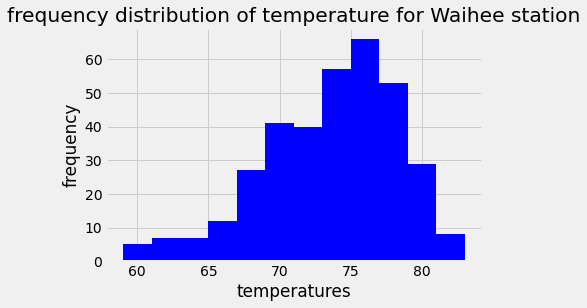

In [112]:
final=session.query(measurement.station, measurement.tobs).\
                            filter(measurement.date>='2016-08-23').\
                                filter(measurement.date<='2017-08-23').\
                                    filter(measurement.station=='USC00519281').all()
temps=[result[1] for result in final]
plt.hist(temps, bins=12, color='blue', label='tobs')
plt.title('frequency distribution of temperature for Waihee station')
plt.ylabel('frequency')
plt.xlabel('temperatures')
plt.show()